In [96]:
import tp3
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd
from faker import Faker
import time
from joblib import dump, load 
import os 

In [97]:
NAME_SIZE = 39
SUBSETS_SIZE = 200

In [98]:
#Library to ganerate ramdon team players 

def generate_fake_names():
    fake = Faker()
    random_names = set()
    random_names_list  = []
    while len(random_names) < NAME_SIZE:
        nombre = fake.name()
        random_names.add(nombre)

    random_names_list = list(random_names)
    return random_names, random_names_list

def generate_substsets(random_names):
    subsets = []
    for i in range(SUBSETS_SIZE): 
        subset = []
        for _ in range(i): 
            new_set = set()
            for k in range(random.randint(1, NAME_SIZE)):
                pos = random.randint(0, NAME_SIZE - 1)
                new_set.add(random_names[pos])
            subset.append(new_set)
        subsets.append(subset)
    return subsets

def generate_substsets_vol(random_names):
    subsets = []
    for i in range(SUBSETS_SIZE): 
        subset = []
        for _ in range(i): 
            new_set = set()
            for k in range(len(random_names)//7):
                pos = random.randint(0, NAME_SIZE - 1)
                new_set.add(random_names[pos])
            subset.append(new_set)
        subsets.append(subset)
    return subsets


def calculate_times(subsets, bt_func, lp_func):    
    time_list_bt = []  
    time_list_lp = []
    lengths = []    
    opts = []
    for i in range(len(subsets)):
        time_bt = 0
        time_lp = 0
        opt = 0
        a_set = reconstruct_set(subsets[i])
        for _ in range(5):
            bt_time_i = time.time()
            bt_sol = bt_func(subsets[i],a_set )
            bt_time_e = time.time()
            elapsed_time_bt = bt_time_e - bt_time_i

            lp_time_i = time.time()
            lp_sol = lp_func(subsets[i], a_set)
            lp_time_e = time.time()
            elapsed_time_lp = lp_time_e - lp_time_i
            
            if (len(bt_sol) != len(lp_sol)):
                continue
            time_bt += elapsed_time_bt
            time_lp += elapsed_time_lp
            opt = len(bt_sol)  
        if (time_bt == 0):
            continue
        time_list_bt.append(time_bt/5)
        time_list_lp.append(time_lp/5)
        lengths.append(len(subsets[i]))
        opts.append(opt)
    return time_list_bt, time_list_lp, lengths, opts


def calculate_aprox_times(subsets, greedy_aprox, lpc_aprox, filter):
    greedy = []  
    lpc = []    
    aprox_by_greedy = []
    aprox_by_clp = []
    for i in filter:
        greedy_time = 0
        lcp_time = 0
        opt_greedy = 0
        opt_lpc = 0
        a_set = reconstruct_set(subsets[i])
        for _ in range(10):
            greed_time_i = time.time()
            greedy_sol = greedy_aprox(subsets[i], a_set)
            greed_time_e = time.time()
            opt_greedy += len(greedy_sol)
            greedy_time += greed_time_e - greed_time_i

            lp_time_i = time.time()
            lpc_sol = lpc_aprox(subsets[i], a_set)
            lp_time_e = time.time()
            opt_lpc += len(lpc_sol)
            lcp_time += lp_time_e - lp_time_i
        greedy.append(greedy_time/10)
        lpc.append(lcp_time/10)
        aprox_by_greedy.append(opt_greedy//10)
        aprox_by_clp.append(opt_lpc//10)
    return greedy, lpc, aprox_by_greedy, aprox_by_clp

def calculate_aprox_times_vol(subsets, greedy_aprox, lpc_aprox):
    greedy = []  
    lpc = []    
    aprox_by_greedy = []
    aprox_by_clp = []
    lengths = []
    for i in range(len(subsets)):
        greedy_time = 0
        lcp_time = 0
        opt_greedy = 0
        opt_lpc = 0
        if (len(subsets[i]) == 0):
            continue
        a_set = reconstruct_set(subsets[i])
        for _ in range(10):
            bt_time_i = time.time()
            greedy_sol = greedy_aprox(subsets[i], a_set)
            bt_time_e = time.time()
            opt_greedy += len(greedy_sol)
            greedy_time += bt_time_e - bt_time_i

            lp_time_i = time.time()
            lpc_sol = lpc_aprox(subsets[i], a_set)
            lp_time_e = time.time()
            opt_lpc += len(lpc_sol)
            lcp_time += lp_time_e - lp_time_i
        greedy.append(greedy_time/10)
        lpc.append(lcp_time/10)
        aprox_by_greedy.append(opt_greedy//10)
        aprox_by_clp.append(opt_lpc//10)
        lengths.append(len(subsets[i]))
    return greedy, lpc, aprox_by_greedy, aprox_by_clp, lengths

def generate_teorical_time(lengths, base):
    teorical_time = []
    for n in lengths:
        teorical_time.append( (base)**n)
        
    return teorical_time

def reconstruct_set(subsets):
    a_set = set()
    for subset in subsets:
        a_set = a_set.union(subset)
    return a_set
    

In [99]:
if not os.path.exists("randomizedData/fake_names.plk") or not os.path.exists("randomizedData/subsets.plk"):
    fake_names, fake_name_list = generate_fake_names()
    subsets = generate_substsets(fake_name_list)
    dump(fake_names, "randomizedData/fake_names.plk")
    dump(subsets, "randomizedData/subsets.plk")
else: 
    fake_names = load("randomizedData/fake_names.plk")
    subsets = load("randomizedData/subsets.plk")

In [100]:
if not os.path.exists("randomizedData/times.csv"):
    bt_time, lp_time, lengths, opts = calculate_times(subsets, tp3.search_for_min_hitting_set, tp3.search_hs_linealp)
    times = pd.DataFrame({'m': lengths, 'bt_time': bt_time, 'ilp_time': lp_time, 'opt': opts})
    greedy, lpc,aprox_by_greedy, aprox_by_clp = calculate_aprox_times(subsets, tp3.aprox_hs_by_greedy, tp3.aprox_hs_by_contlp, times['m'])
    times['greed_t'] = greedy
    times['lpc_t'] = lpc
    times['opt_greedy'] = aprox_by_greedy
    times['opt_clp'] = aprox_by_clp
    times.to_csv('randomizedData/times.csv', index=False)
else: 
    times = pd.read_csv('randomizedData/times.csv')

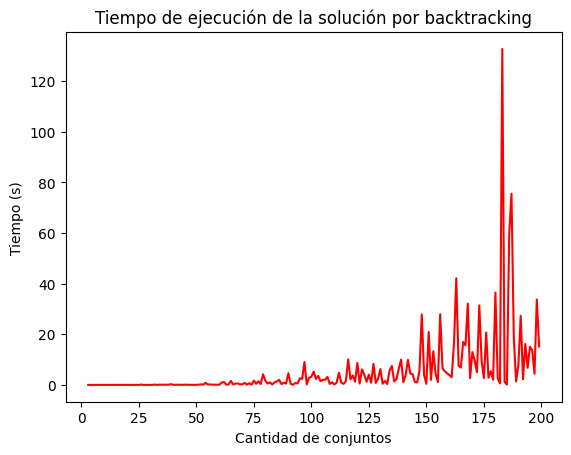

In [101]:
plt.plot(times['m'], times['bt_time'], label='linealp', color='red')
plt.title('Tiempo de ejecución de la solución por backtracking')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')
plt.savefig('imagenes/backtracking.png')

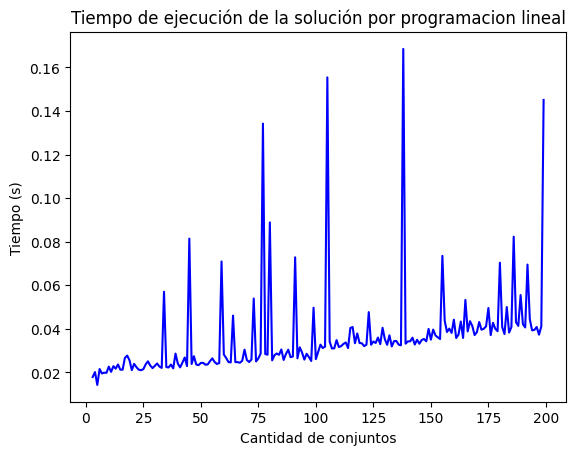

In [102]:
plt.plot(times['m'], times['ilp_time'], label='linealp', color='blue')
plt.title('Tiempo de ejecución de la solución por programacion lineal')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')
plt.savefig('imagenes/integerp.png')

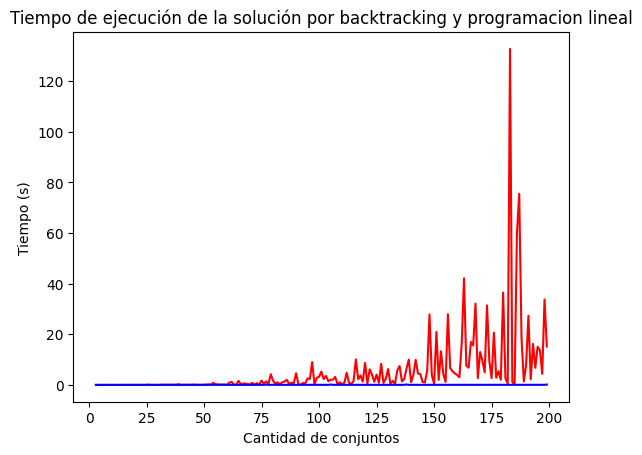

In [103]:
plt.plot(times['m'], times['bt_time'], label='backtracking', color='red')
plt.plot(times['m'], times['ilp_time'], label='linealp', color='blue')
plt.title('Tiempo de ejecución de la solución por backtracking y programacion lineal')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')
plt.savefig('imagenes/ilpvsbt.png')

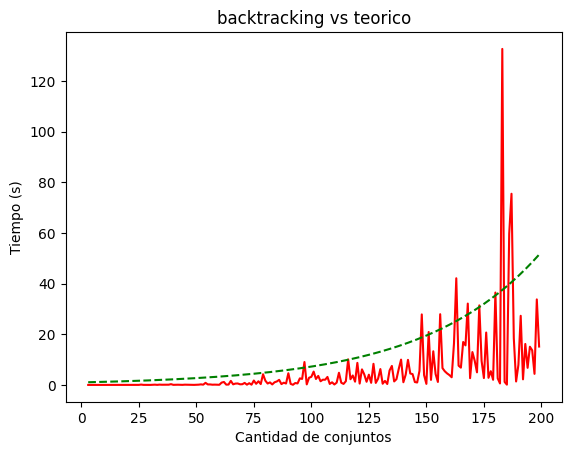

In [104]:
plt.plot(times['m'], times['bt_time'], label='backtracking', color='red')
plt.plot(times['m'], generate_teorical_time(times['m'], 1.02), label='teorico', color='green', linestyle='dashed')
plt.title('backtracking vs teorico')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')
plt.legend()
plt.show()
plt.savefig('imagenes/backvsteorico.png')

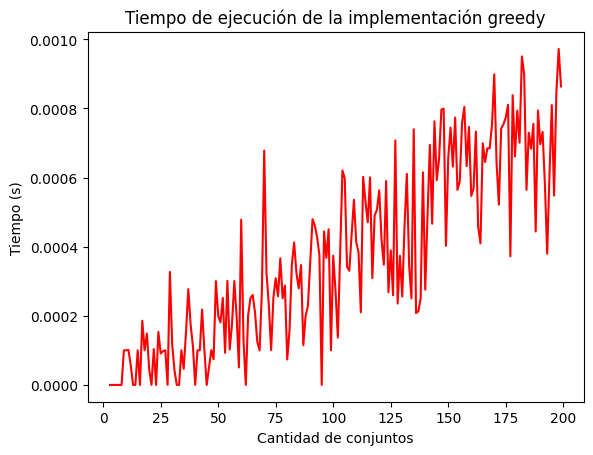

In [121]:
plt.plot(times['m'], times['greed_t'], label='backtracking', color='red')
plt.ylabel('Tiempo (s)')
plt.title("Tiempo de ejecución de la implementación greedy")
plt.xlabel('Cantidad de conjuntos')
plt.savefig('imagenes/greed.png')

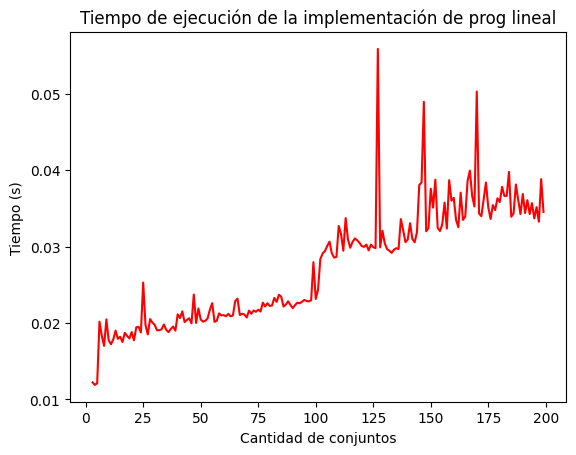

In [123]:
plt.plot(times['m'], times['lpc_t'], label='backtracking', color='red')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')
plt.title("Tiempo de ejecución de la implementación de prog lineal")
plt.savefig('imagenes/continous.png')

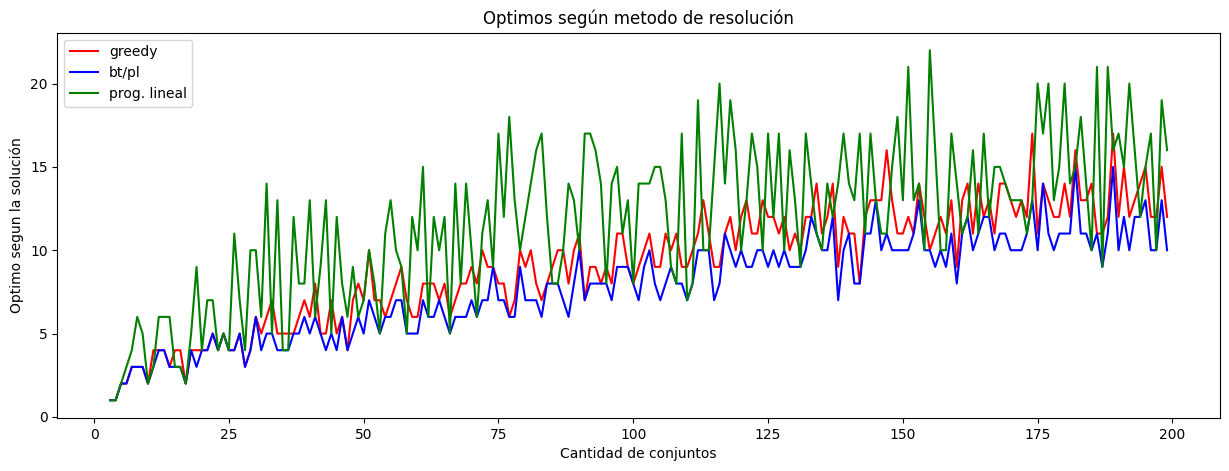

<Figure size 640x480 with 0 Axes>

In [119]:
plt.figure(figsize=(15,5))
plt.plot(times['m'], times['opt_greedy'], label='greedy', color='red')
plt.plot(times['m'], times['opt'], label='bt/pl', color='blue')
plt.plot(times['m'], times['opt_clp'], label='prog. lineal', color='green')
plt.ylabel('Optimo segun la solución')
plt.xlabel('Cantidad de conjuntos')
plt.title("Optimos según metodo de resolución")
plt.legend()
plt.show()
plt.savefig('imagenes/optimos.png')


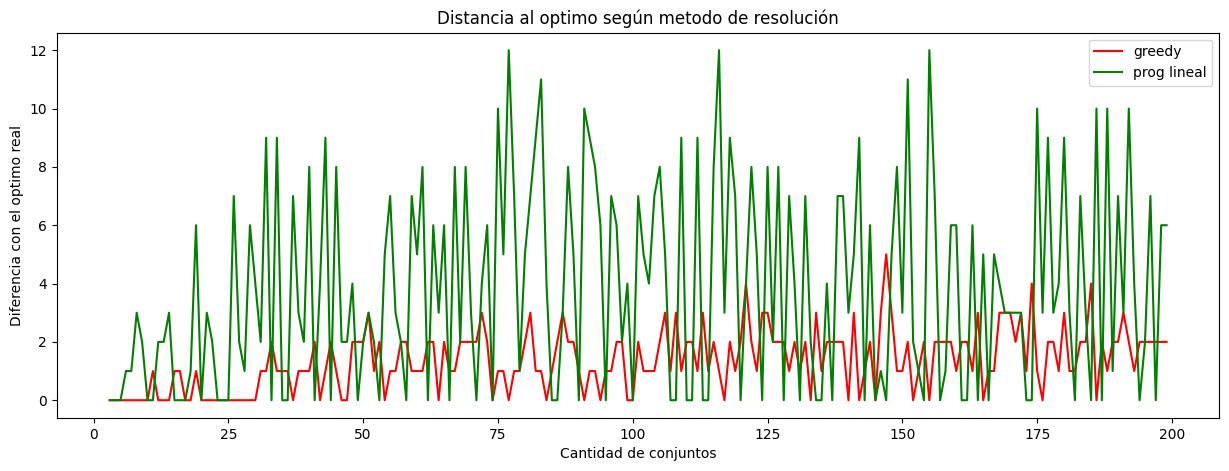

<Figure size 640x480 with 0 Axes>

In [120]:
plt.figure(figsize=(15,5))
plt.plot(times['m'], times['opt_greedy'] - times['opt'], label='greedy', color='red')
plt.plot(times['m'], times['opt_clp'] - times['opt'] , label='prog lineal', color='green')
plt.ylabel('Diferencia con el optimo real')
plt.xlabel('Cantidad de conjuntos')
plt.title("Distancia al optimo según metodo de resolución")
plt.legend()
plt.show()
plt.savefig('imagenes/distaloptimo.png')

In [108]:
NAME_SIZE = 60
SUBSETS_SIZE = 400

In [109]:
if not os.path.exists("randomizedData/fake_names_aprox.plk") or not os.path.exists("randomizedData/subsets_aprox.plk"):
    fake_names_aprox, fake_name_list_aprox = generate_fake_names()
    subsets_aprox = generate_substsets_vol(fake_name_list_aprox)
    dump(fake_names_aprox, "randomizedData/fake_names_aprox.plk")
    dump(subsets_aprox, "randomizedData/subsets_aprox.plk")
else:
    fake_names_aprox = load("randomizedData/fake_names_aprox.plk")
    subsets_aprox = load("randomizedData/subsets_aprox.plk")
    fake_name_list_aprox = list(fake_names_aprox)

In [110]:
if not os.path.exists("randomizedData/aprox_times.csv"):
    greedy, lpc, aprox_by_greedy, aprox_by_clp, lengths = calculate_aprox_times_vol(subsets_aprox, tp3.aprox_hs_by_greedy, tp3.aprox_hs_by_contlp)
    aprox_times = pd.DataFrame({'m': lengths, 'greedy': greedy, 'lpc': lpc, 'opt_greedy': aprox_by_greedy, 'opt_clp': aprox_by_clp})
    aprox_times.to_csv('randomizedData/aprox_times.csv', index=False)
else:
    aprox_times = pd.read_csv('randomizedData/aprox_times.csv')